In [1]:
import os
import sys
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# tests

In [2]:
unpickled_df = pd.read_pickle("../synced_full_data.pkl")  
unpickled_df  

timestamps                                         detections  \
0     1.618047e+09  [[0, [-0.6094234784376035, -0.3949167701311605...   
1     1.618047e+09  [[0, [-0.6269636328164907, -0.3773853513090304...   
2     1.618047e+09  [[4, [-1.5177742579302416, -0.2248669958750161...   
3     1.618047e+09  [[4, [-1.4822994540755319, -0.2154964909636787...   
4     1.618047e+09  [[0, [-0.7023300951879954, -0.3708721015910065...   
...            ...                                                ...   
1258  1.618048e+09  [[461, [0.24336739589325554, -0.27350227356064...   
1259  1.618048e+09  [[461, [0.20893056526876183, -0.26728642968195...   
1260  1.618048e+09  [[461, [0.1790934761769166, -0.250180570148284...   
1261  1.618048e+09  [[459, [0.5527448113363217, -0.190363778344885...   
1262  1.618048e+09  [[459, [0.5105027450361204, -0.162216426076331...   

                                               img_msgs  \
0     [[[144, 144, 144], [156, 156, 156], [174, 178,...   
1     [[[176, 174, 177], [191, 189, 193], [189, 192,...   
2     [[[191, 194, 188], [193, 196, 190], [196, 196,...   
3     [[[194, 196, 193], [194, 196, 193], [196, 197,...   
4     [[[198, 198, 192], [198, 198, 192], [196, 199,...   
...                                                 ...   
1258  [[[115, 106, 102], [135, 126, 121], [139, 140,...   
1259  [[[113, 104, 96], [134, 125, 117], [137, 137, ...   
1260  [[[111, 97, 93], [134, 120, 117], [136, 138, 1...   
1261  [[[110, 89, 86], [135, 115, 112], [137, 134, 1...   
1262  [[[104, 85, 91], [126, 107, 113], [135, 135, 1...   

                                               vox_msgs  
0     [[81, 9], [79, 12], [40, 28], [12, 49], [5, 17...  
1     [[81, 9], [79, 12], [40, 28], [12, 49], [5, 17...  
2     [[81, 9], [79, 12], [40, 28], [12, 49], [5, 17...  
3     [[80, 12], [57, 21], [63, 63], [59, 21], [58, ...  
4     [[35, 30], [44, 23], [45, 14], [42, 25], [43, ...  
...                                                 ...  
1258  [[78, 44], [77, 45], [41, 41], [77, 46], [62, ...  
1259  [[48, 37], [61, 69], [38, 36], [77, 40], [46, ...  
1260  [[49, 39], [33, 49], [77, 43], [39, 37], [44, ...  
1261  [[39, 37], [77, 43], [52, 40], [43, 33], [48, ...  
1262  [[78, 42], [32, 44], [77, 43], [52, 40], [43, ...  

[1263 rows x 4 columns]

In [48]:
def draw_boxes(frame, detections):
    # Draw bounding boxes for tracked objects
    for object in detections:
        if type(object[0])== int:
            x, y, w, h = object[2]
            x, y, w, h = int(x), int(y), int(w), int(h)
            object_id = object[0]
            confidence = object[-1]
            frame = cv.rectangle(frame, (x, y), (w, h), (0, 255, 0), 2)
            frame = cv.putText(frame, f"{str(object_id)}: {str(round(confidence, 2))}", (x, y - 10), cv.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    return frame

In [5]:
# filter trajectories with enough detected keypoints and length of sequence
def filter_detections_id_pose(index, row):
    old_detections = row["detections"]
    new_detections = []
    for object in old_detections:
        if type(object[0])== int:
            object_id = object[0]
            confidence = object[-1]
            pose_kps = object[3]
            pose_confs = np.asarray(pose_kps)[:,-1]
            if len(np.argwhere(pose_confs > 0.5)) > 8 and not type(confidence) == list:
                if confidence > 0.7:
                    new_detections.append([object_id, object[1], object[2], pose_kps, object[4]])
    unpickled_df.update(pd.DataFrame({'detections': [new_detections]}, index=[index]))


In [6]:
for index, row in unpickled_df.iterrows():
    filter_detections_id_pose(index, row)
    img = row["img_msgs"].astype(np.uint8)
    img = draw_boxes(img, row["detections"])
    cv.imshow("frame", img)
    cv.waitKey(50)

cv.destroyAllWindows()

In [7]:
def filter_seq_len():
    ids = []
    detections = unpickled_df.iloc[:]["detections"]
    all_ids = [x[0] for y in detections for x in y]
    occurs_id, occurs_counts = np.unique(np.asarray(all_ids), return_counts=True)
    occurs_idx = np.argwhere(occurs_counts>20) # TODO: parameter, gucekn wie viel übrig bleibt
    ids = occurs_id[occurs_idx]
    return np.squeeze(ids)
keep_ids = filter_seq_len()
print(keep_ids)

[  0   1   5  25  44  46  59  65  67  72  75  78  81  88  92 105 117 130
 134 144 149 150 151 159 209 227 234 236 238 239 243 249 254 255 259 260
 262]


In [8]:
def filter_ids(ids):
    old_detections = row["detections"]
    new_detections = []
    for object in old_detections:
        if np.isin(object[0], ids):
            object_id = object[0]
            confidence = object[-1]
            pose_kps = object[3]
            pose_confs = np.asarray(pose_kps)[:,-1]
            if len(np.argwhere(pose_confs > 0.5)) > 8:
                if confidence > 0.7:
                    new_detections.append([object_id, object[1], object[2], pose_kps, object[4]])
    unpickled_df.update(pd.DataFrame({'detections': [new_detections]}, index=[index]))

In [9]:
for index, row in unpickled_df.iterrows():
    filter_ids(keep_ids)

In [10]:
for index, row in unpickled_df.iterrows():
    img = row["img_msgs"].astype(np.uint8)
    img = draw_boxes(img, row["detections"])
    cv.imshow("frame", img)
    cv.waitKey(50)

cv.destroyAllWindows()

# Full process of filtering

In [3]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

In [9]:
def draw_boxes(frame, detections):
    # Draw bounding boxes for tracked objects
    for object in detections:
        if type(object[0])== int:
            x, y, w, h = object[2]
            x, y, w, h = int(x), int(y), int(w), int(h)
            object_id = object[0]
            confidence = object[-1]
            frame = cv.rectangle(frame, (x, y), (w, h), (0, 255, 0), 2)
            frame = cv.putText(frame, f"{str(object_id)}: {str(round(confidence, 2))}", (x, y - 10), cv.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    return frame

def get_cropped_img(bbox, img):
    x, y, w, h = bbox
    x, y, w, h = int(x), int(y), int(w), int(h)
    cropped_img = img.copy()[y:h, x:w]
    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
    return cropped_img

def pad_img(im):
    desired_size = 368
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv.copyMakeBorder(im, top, bottom, left, right, cv.BORDER_CONSTANT,
        value=color)
    
    return new_im

def compare_images(imageA, imageB, title):
	# compute the mean squared error and structural similarity
	# index for the images
	
	m = mse(imageA, imageB)
	s = ssim(imageA, imageB, channel_axis=2)

	if s < 0.7:
		# setup the figure
		fig = plt.figure(title)
		plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
		# show first image
		ax = fig.add_subplot(1, 2, 1)
		plt.imshow(imageA, cmap = plt.cm.gray)
		plt.axis("off")
		# show the second image
		ax = fig.add_subplot(1, 2, 2)
		plt.imshow(imageB, cmap = plt.cm.gray)
		plt.axis("off")
		# show the images
		plt.show()
	return s

# filter trajectories with enough detected keypoints and length of sequence
def filter_detections_id_pose(index, row):
    old_detections = row["detections"]
    new_detections = []
    for object in old_detections:
        if type(object[0])== int:
            object_id = object[0]
            confidence = object[-1]
            pose_kps = object[3]
            pose_confs = np.asarray(pose_kps)[:,-1]
            if len(np.argwhere(pose_confs > 0.5)) > 8 and not type(confidence) == list:
                if confidence > 0.7:
                    new_detections.append([object_id, object[1], object[2], pose_kps, object[4]])
    unpickled_df.update(pd.DataFrame({'detections': [new_detections]}, index=[index]))

def filter_seq_len():
    ids = []
    detections = unpickled_df.iloc[:]["detections"]
    all_ids = [x[0] for y in detections for x in y]
    occurs_id, occurs_counts = np.unique(np.asarray(all_ids), return_counts=True)
    occurs_idx = np.argwhere(occurs_counts>10) # TODO: parameter, gucekn wie viel übrig bleibt
    ids = occurs_id[occurs_idx]
    return np.squeeze(ids)

def filter_ids(ids):
    old_detections = row["detections"]
    if index - 1 >= 0:
        older_detections = unpickled_df.iloc[index-1]["detections"]
    else:
        older_detections = old_detections
    new_detections = []
    for object in old_detections:
        previous_ids = np.asarray([x[0] for x in older_detections ])
        if np.isin(object[0], ids) and np.isin(object[0], previous_ids):
            # check if old cropped and new cropped by bounding box image are similar and correct tracked
            for object_old in older_detections:
                if object_old[0] == id:
                    old_crop = pad_img(get_cropped_img(object_old[2], unpickled_df.iloc[index-1]["img_msgs"]))
                    new_crop = pad_img(get_cropped_img(object[2], img))
                    sim = compare_images(old_crop, new_crop, id)
                    if sim > 0.6:
                        # get detection information and pose
                        object_id = object[0]
                        confidence = object[-1]
                        pose_kps = object[3]
                        pose_confs = np.asarray(pose_kps)[:,-1]
                        new_detections.append([object_id, object[1], object[2], pose_kps, object[4]])
                    else:
                        # delete id from list to keep intact sequence
                        i = np.argwhere(ids==id)
                        ids = np.delete(ids, index)
    unpickled_df.update(pd.DataFrame({'detections': [new_detections]}, index=[index]))

In [10]:
# load data
#unpickled_df = pd.read_pickle("synced_full_data.pkl")  


for index, row in unpickled_df.iterrows():
    filter_detections_id_pose(index, row)

keep_ids = filter_seq_len()

for index, row in unpickled_df.iterrows():
    filter_ids(keep_ids)

for index, row in unpickled_df.iterrows():
    img = row["img_msgs"].astype(np.uint8)
    img = draw_boxes(img, row["detections"])
    cv.imshow("frame", img)
    cv.waitKey(50)

cv.destroyAllWindows()

In [21]:
### version 2: keep sequences in full length

unpickled_df = pd.read_pickle("synced_full_data.pkl")  



for index, row in unpickled_df.copy().iterrows():
    filter_detections_id_pose(index, row)

keep_ids = filter_seq_len()

for index, row in unpickled_df.iterrows():
    filter_ids(keep_ids)

for index, row in unpickled_df.iterrows():
    img = row["img_msgs"].astype(np.uint8)
    img = draw_boxes(img, row["detections"])
    cv.imshow("frame", img)
    cv.waitKey(50)

cv.destroyAllWindows()

In [22]:
unpickled_df

timestamps                                         detections  \
0     1.616680e+09  [[0, [-0.38936211035001733, -0.027513600453769...   
1     1.616680e+09  [[1, [2.434882329030057, 0.008162512861874015,...   
2     1.616680e+09  [[0, [-0.40092064309254183, -0.021737212341631...   
3     1.616680e+09  [[1, [2.383170036323165, 0.008162512861874015,...   
4     1.616680e+09  [[0, [-0.3997900988003534, -0.0190707714418641...   
...            ...                                                ...   
1041  1.616680e+09                                                 []   
1042  1.616680e+09                                                 []   
1043  1.616680e+09                                                 []   
1044  1.616680e+09                                                 []   
1045  1.616680e+09                                                 []   

                                               img_msgs  \
0     [[[4, 6, 24], [4, 6, 24], [5, 4, 28], [4, 3, 2...   
1     [[[4, 3, 27], [3, 2, 26], [3, 7, 21], [4, 8, 2...   
2     [[[7, 6, 26], [8, 7, 27], [7, 6, 26], [6, 4, 2...   
3     [[[5, 4, 28], [4, 3, 27], [7, 8, 19], [6, 6, 1...   
4     [[[6, 11, 19], [5, 10, 18], [6, 9, 20], [6, 9,...   
...                                                 ...   
1041  [[[124, 114, 112], [125, 115, 114], [129, 114,...   
1042  [[[221, 215, 192], [219, 212, 190], [210, 193,...   
1043  [[[253, 255, 253], [252, 255, 252], [213, 204,...   
1044  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1045  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                                               vox_msgs  
0     [[5, 20], [15, 33], [12, 29], [11, 27], [19, 3...  
1     [[3, 78], [24, 38], [19, 53], [1, 78], [16, 32...  
2     [[6, 77], [16, 60], [46, 33], [2, 82], [26, 32...  
3     [[25, 79], [24, 58], [23, 58], [21, 32], [23, ...  
4     [[25, 60], [53, 56], [24, 88], [27, 55], [25, ...  
...                                                 ...  
1041  [[37, 70], [34, 56], [35, 61], [35, 37], [37, ...  
1042  [[37, 70], [34, 56], [35, 61], [35, 37], [37, ...  
1043  [[37, 70], [34, 56], [35, 61], [35, 37], [37, ...  
1044  [[37, 70], [34, 56], [35, 61], [35, 37], [37, ...  
1045  [[37, 70], [34, 56], [35, 61], [35, 37], [37, ...  

[1046 rows x 4 columns]

# Filter Re-Id

In [2]:
sync_data = pd.read_pickle("../synced_data/data_2021-04-10-11-28-10-009.pkl")

In [3]:
detections = sync_data.iloc[:]["detections"]
all_ids = [x[0] for y in detections for x in y]
occurs_id, occurs_counts = np.unique(np.asarray(all_ids), return_counts=True)

In [4]:
def pad_img(im):
    desired_size = 368
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv.copyMakeBorder(im, top, bottom, left, right, cv.BORDER_CONSTANT,
        value=color)
    
    return new_im

In [5]:
occurs_id

array([  0,   1,   2,  15,  19,  21,  24,  29,  30,  31,  40,  47,  50,
        53,  56,  65,  70,  90,  99, 111, 114, 122, 151, 166, 180, 248,
       250, 254, 258, 289, 352, 368, 380, 383, 385, 388, 394, 397, 409,
       421, 423, 435, 439, 446, 451, 469, 480, 499, 507])

In [6]:
def get_cropped_img(bbox, img):
    x, y, w, h = bbox
    x, y, w, h = int(x), int(y), int(w), int(h)
    cropped_img = img.copy()[y:h, x:w]
    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
    return cropped_img

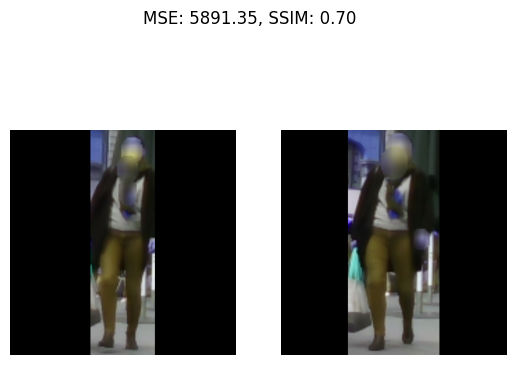

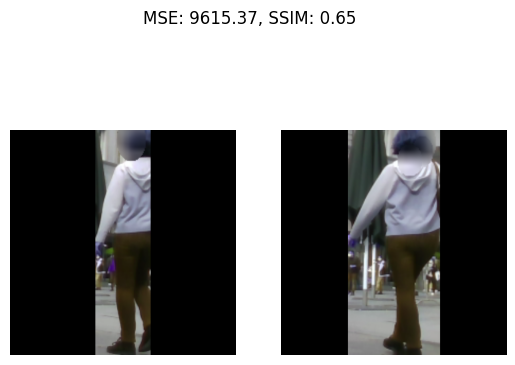

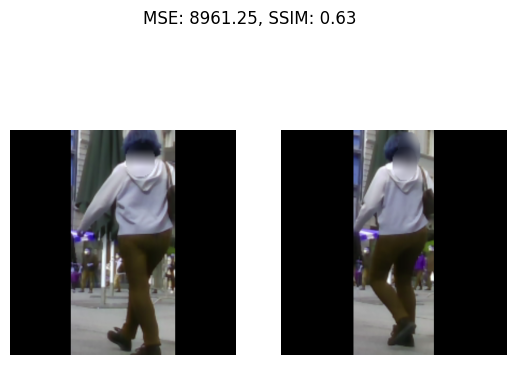

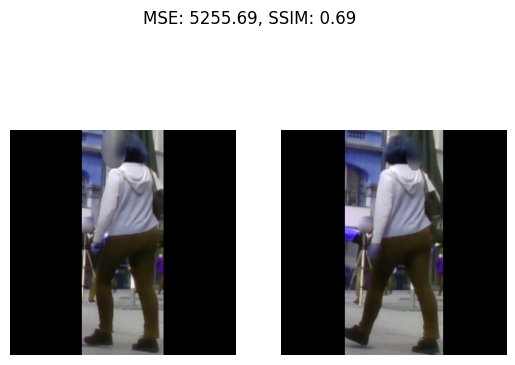

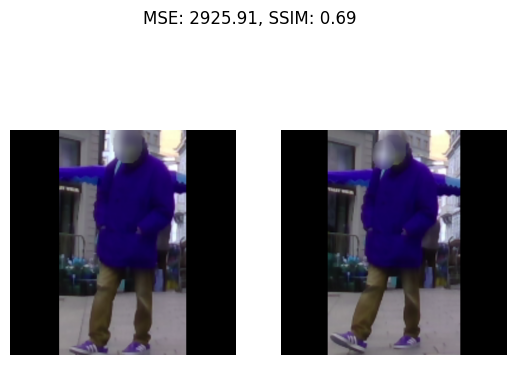

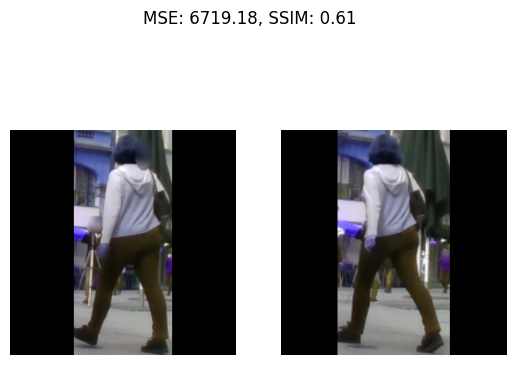

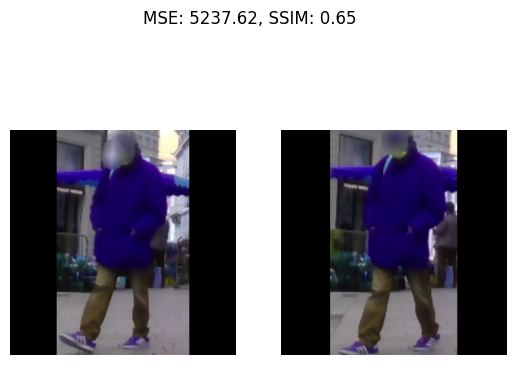

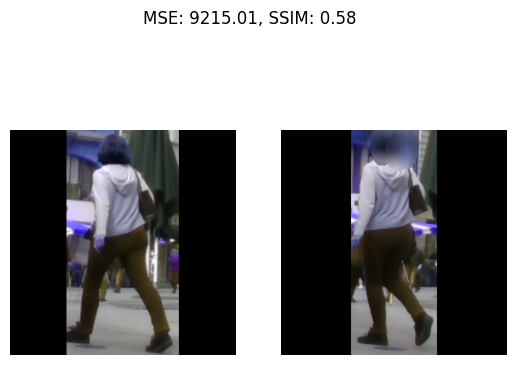

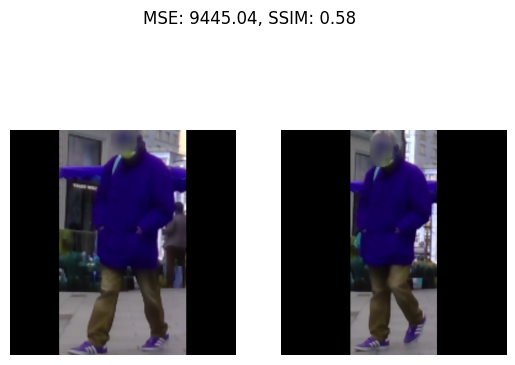

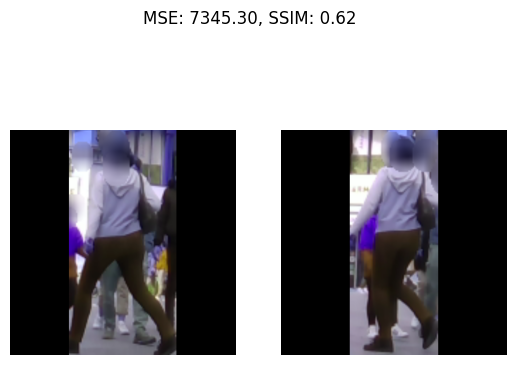

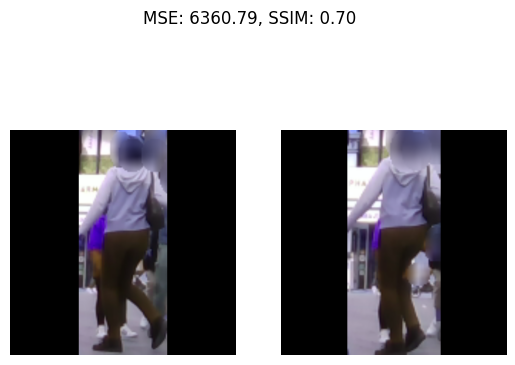

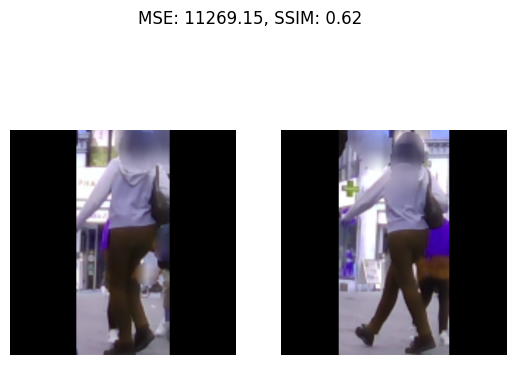

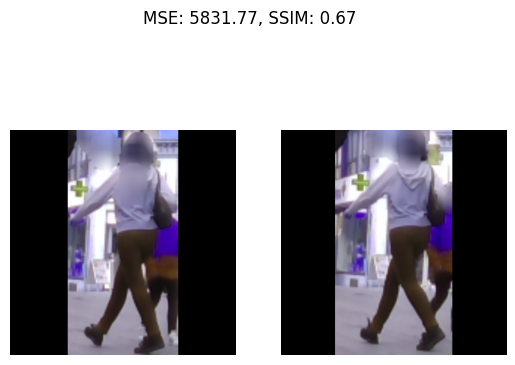

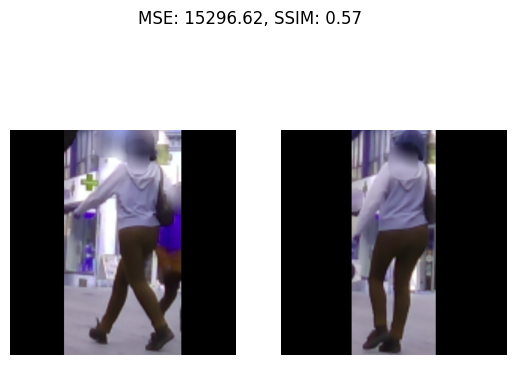

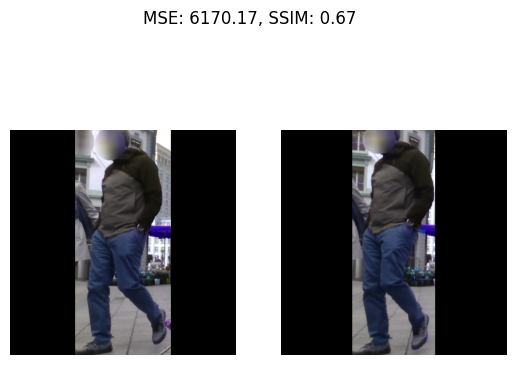

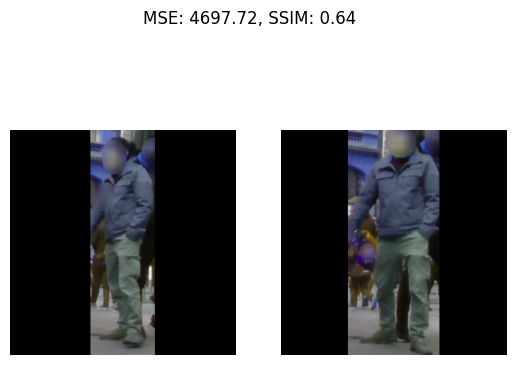

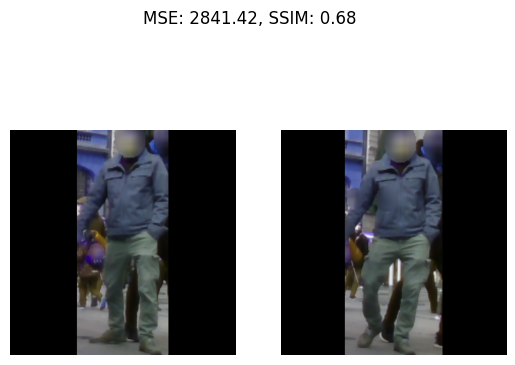

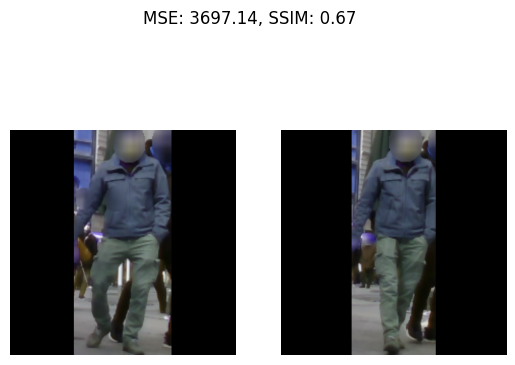

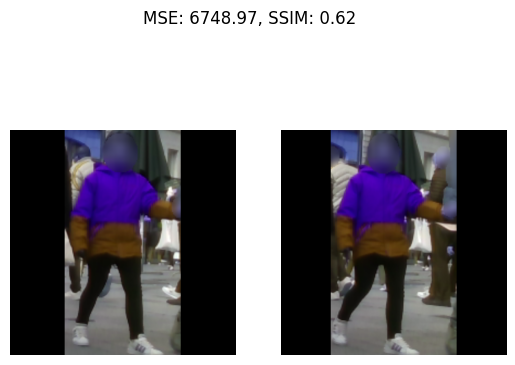

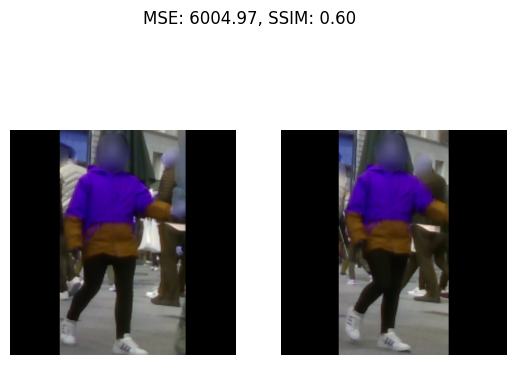

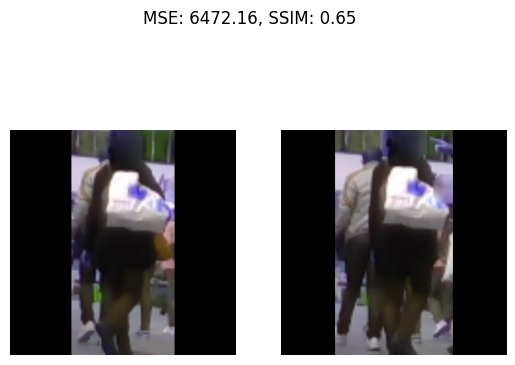

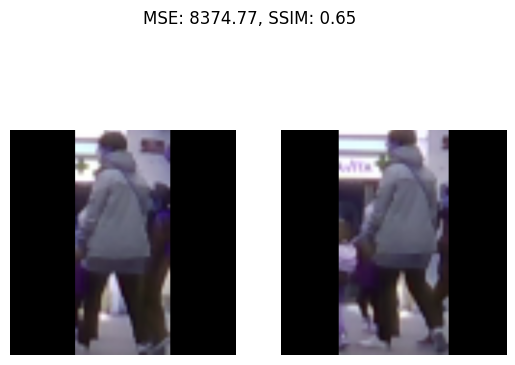

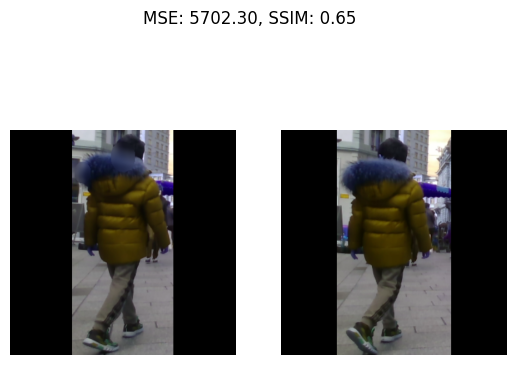

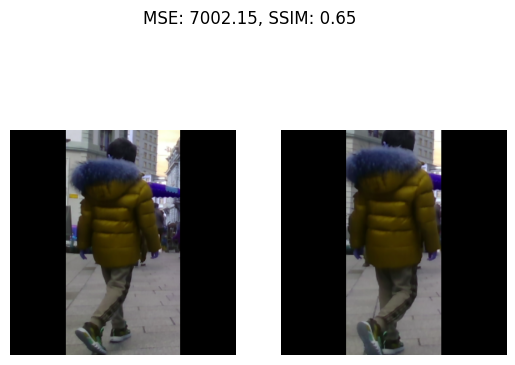

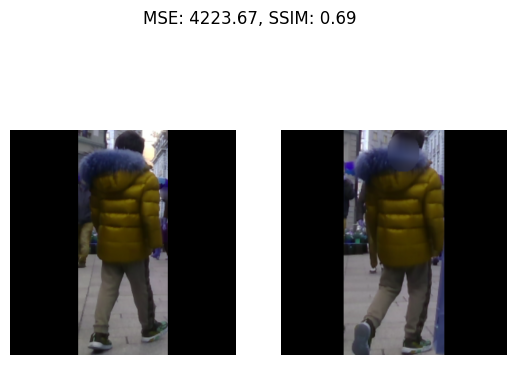

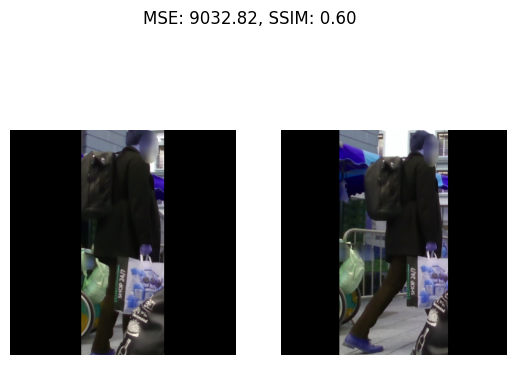

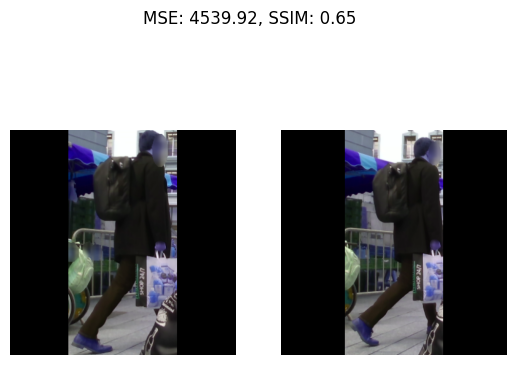

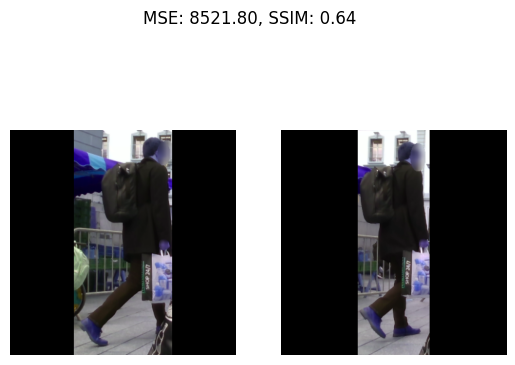

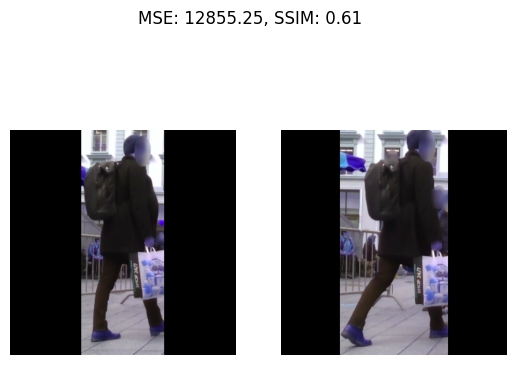

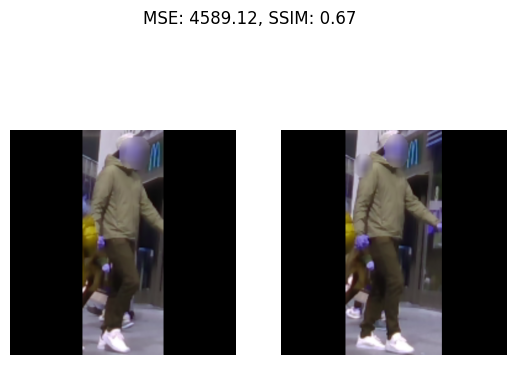

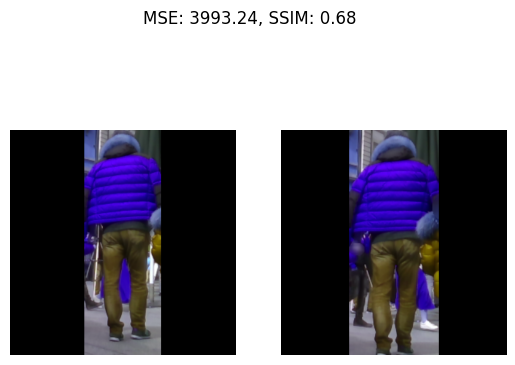

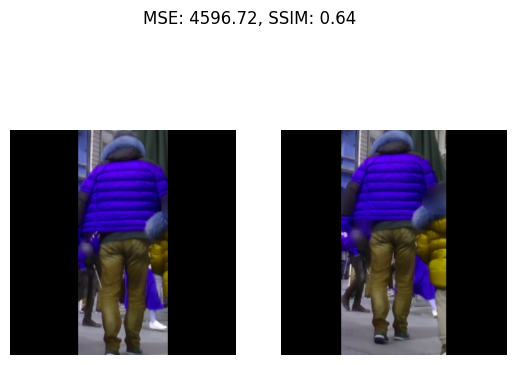

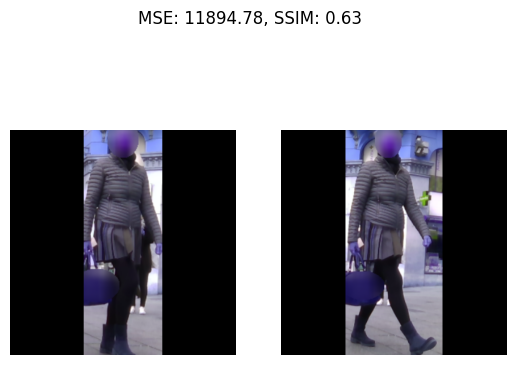

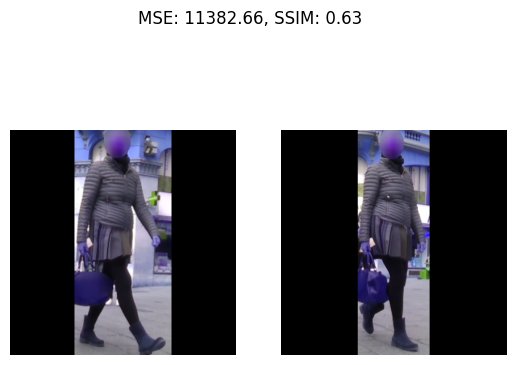

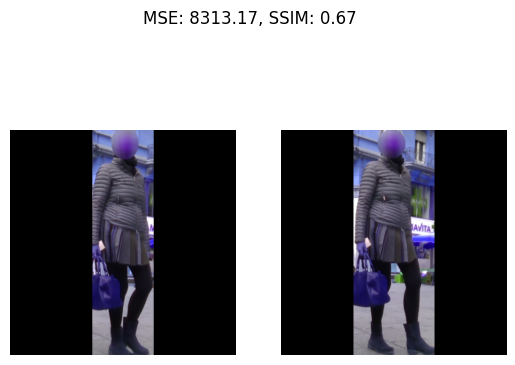

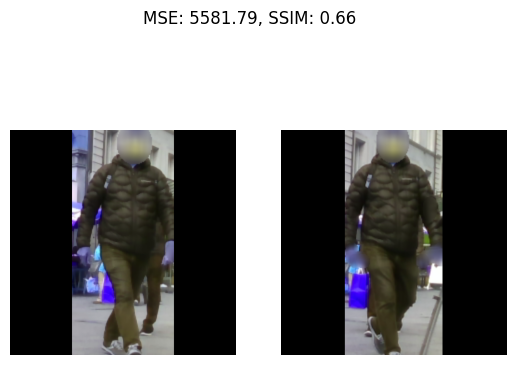

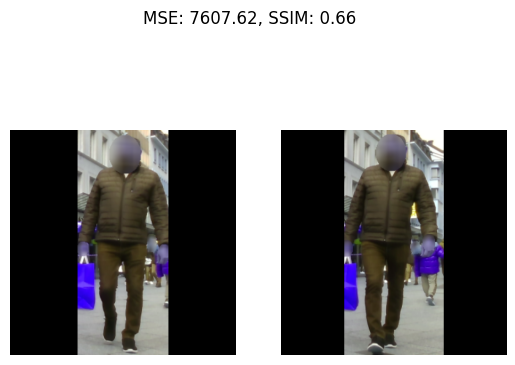

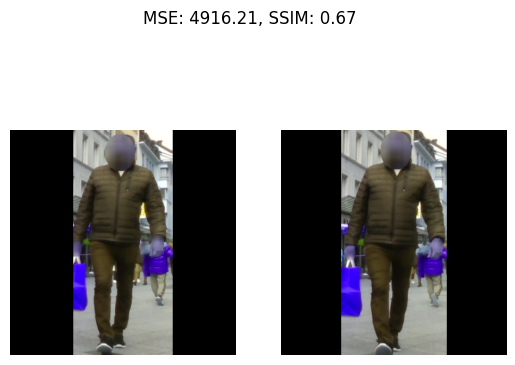

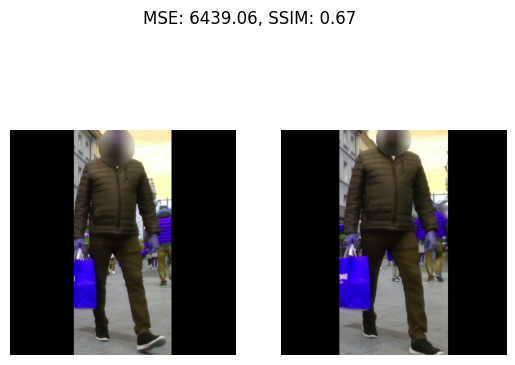

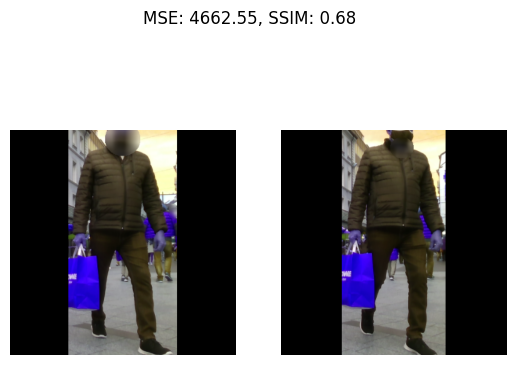

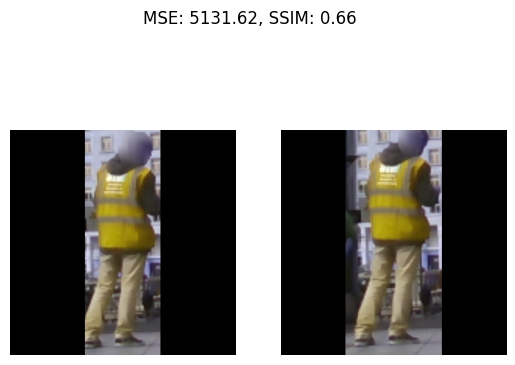

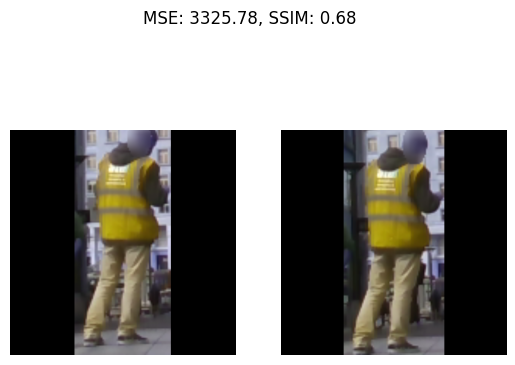

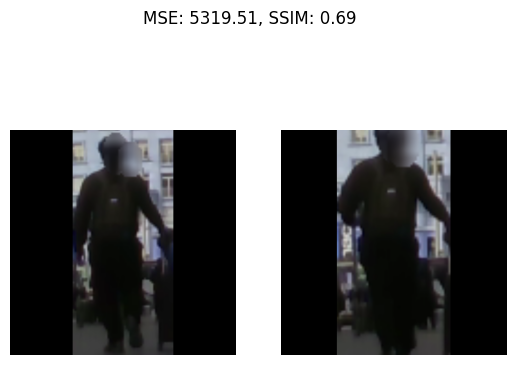

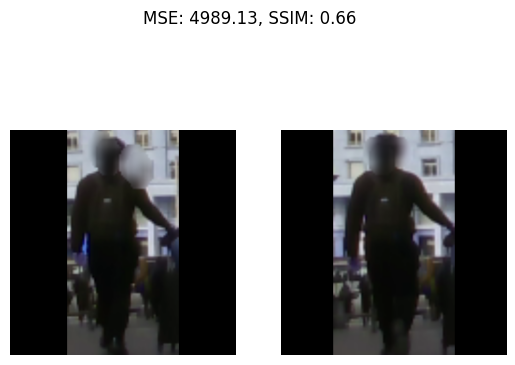

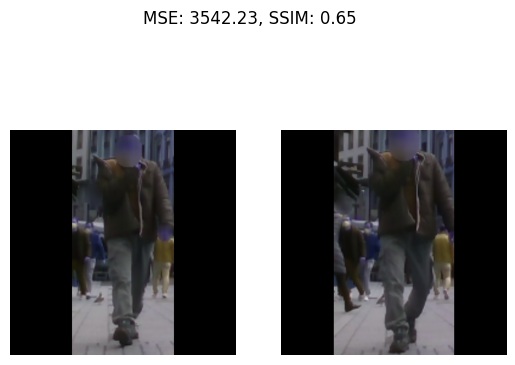

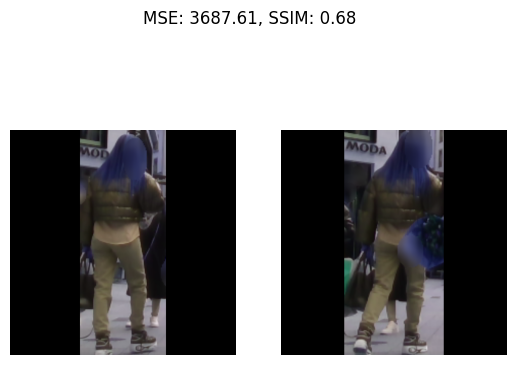

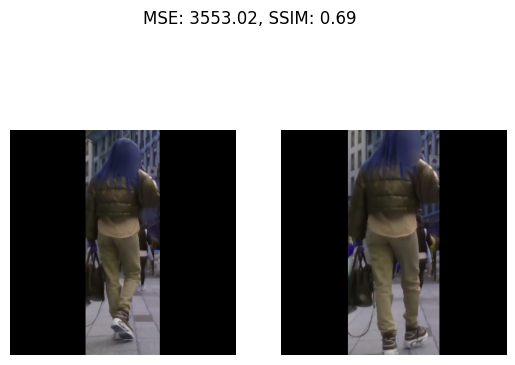

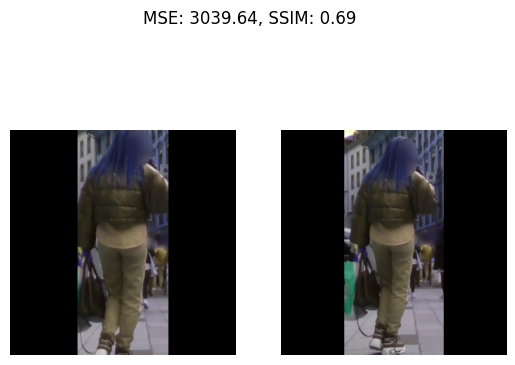

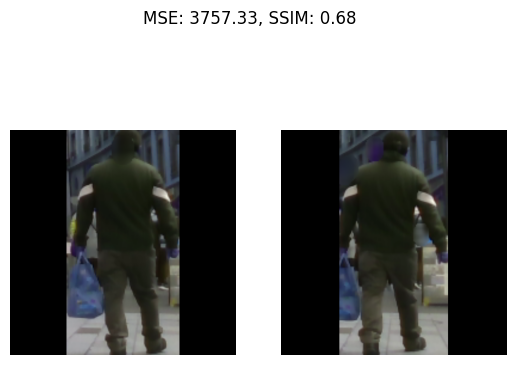

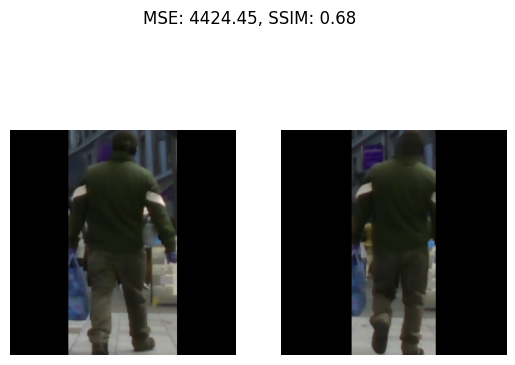

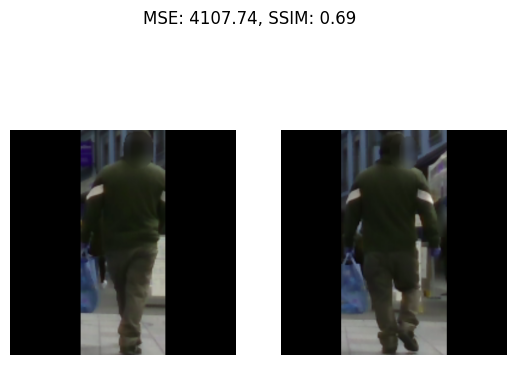

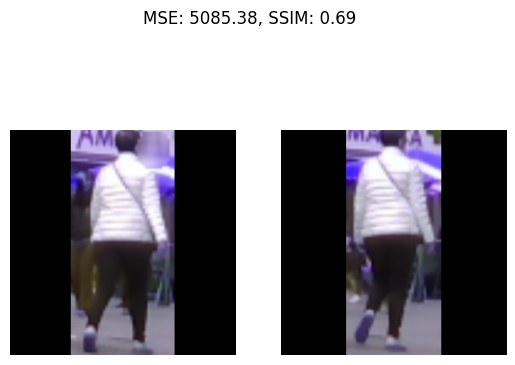

In [44]:
# get current and previous row, compare detections with same id if same person with realignid
imgs = []
old_crop = []
new_crop = []
for index, row in sync_data.iterrows():
    if not index == 0:
        img = row["img_msgs"].astype(np.uint8)
        prev = sync_data.iloc[index-1]
        prev_det = prev["detections"]
        prev_img = prev["img_msgs"].astype(np.uint8)
        for object in row["detections"]:
            # get object id
            id = object[0]
            # get previous detection if available
            for object_old in prev_det:
                if object_old[0] == id:
                    old_crop = pad_img(get_cropped_img(object_old[2], prev_img))
                    new_crop = pad_img(get_cropped_img(object[2], img))
                    compare_images(old_crop, new_crop, id)
                    break


In [39]:
# compare content of images based on ssim and/or mse https://pyimagesearch.com/2014/09/15/python-compare-two-images/
from skimage.metrics import structural_similarity as ssim

def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def compare_images(imageA, imageB, title):
	# compute the mean squared error and structural similarity
	# index for the images
	
	m = mse(imageA, imageB)
	s = ssim(imageA, imageB, channel_axis=2)

	if s < 0.7:
		# setup the figure
		fig = plt.figure(title)
		plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
		# show first image
		ax = fig.add_subplot(1, 2, 1)
		plt.imshow(imageA, cmap = plt.cm.gray)
		plt.axis("off")
		# show the second image
		ax = fig.add_subplot(1, 2, 2)
		plt.imshow(imageB, cmap = plt.cm.gray)
		plt.axis("off")
		# show the images
		plt.show()


# Get single tracks

In [39]:
import imageio
from deep_sort_realtime.deepsort_tracker import DeepSort
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
import torchreid

In [71]:
sync_data = pd.read_pickle("../synced_data/data_2021-04-10-11-30-57-010.pkl")

In [12]:
def pad_img(im):
    desired_size = 368
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv.copyMakeBorder(im, top, bottom, left, right, cv.BORDER_CONSTANT,
        value=color)
    
    return new_im

In [72]:
detections = sync_data.iloc[:]["detections"]
all_ids = [x[0] for y in detections for x in y]
occurs_id, occurs_counts = np.unique(np.asarray(all_ids), return_counts=True)
occurs_id

array([  0,   1,   3,   4,  17,  18,  21,  22,  23,  26,  29,  36,  37,
        38,  40,  52,  62,  71,  75,  78,  85, 103, 110, 111, 123, 124,
       129, 134, 151, 162, 172, 183, 195, 234, 240, 248, 252, 258, 261,
       277, 278, 279, 286, 295, 310, 314])

In [22]:
extractor = torchreid.utils.FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='../osnet_x1_0_imagenet.pth',
    device='cpu'
)

/home/pbr-student/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torchreid/reid/utils/tools.py:43: UserWarning: No file found at "../osnet_x1_0_imagenet.pth"
  warnings.warn('No file found at "{}"'.format(fpath))
Downloading...
From: https://drive.google.com/uc?id=1LaG1EJpHrxdAxKnSCJ_i0u-nbxSAeiFY
To: /home/pbr-student/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth
100%|██████████| 10.9M/10.9M [00:07<00:00, 1.52MB/s]

Successfully loaded imagenet pretrained weights from "/home/pbr-student/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352


In [77]:
def filter_tracks(curr_id, sync_data):
    imgs  =[]
    mses = []
    coss = []
    for index, row in sync_data.iterrows():
        img = row["img_msgs"].astype(np.uint8)
        for object in row["detections"]:
            if type(object[0])== int:
                if object[0] == curr_id:
                    x, y, w, h = object[2]
                    x, y, w, h = int(x), int(y), int(w), int(h)
                    cropped_img = img.copy()[y:h, x:w]
                    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
                    cropped_img = pad_img(cropped_img)
                    if len(imgs)>0:
                        s = ssim(imgs[-1], cropped_img, channel_axis=2)
                        features = extractor([imgs[-1], cropped_img]).numpy()
                        m = mse(features[0], features[1])
                        mses.append(m)
                        cos = 1 - spatial.distance.cosine(features[0], features[1])
                        coss.append(cos)
                    
                        if m < 0.6 and cos > 0.8:
                            imgs.append(cropped_img)
                    else:
                        imgs.append(pad_img(cropped_img))



    imgs = np.asarray(imgs)
    if len(imgs) > 10:
        path = "./animations_" + str(curr_id) + ".gif"
        imageio.mimsave(path, imgs, duration=len(imgs))

In [78]:
for i in occurs_id:
    filter_tracks(i, sync_data)

In [74]:
def filter_tracks2(curr_id, sync_data):
    imgs  =[]
    mses = []
    coss = []
    for index, row in sync_data.iterrows():
        img = row["img_msgs"].astype(np.uint8)
        for object in row["detections"]:
            if type(object[0])== int:
                if object[0] == curr_id:
                    x, y, w, h = object[2]
                    x, y, w, h = int(x), int(y), int(w), int(h)
                    cropped_img = img.copy()[y:h, x:w]
                    cropped_img = np.asarray(cropped_img.copy(),dtype=np.uint8)
                    cropped_img = pad_img(cropped_img)
                    if len(imgs)>0:
                        s = ssim(imgs[-1], cropped_img, channel_axis=2)
                        features = extractor([imgs[-1], cropped_img]).numpy()
                        m = mse(features[0], features[1])
                        mses.append(m)
                        cos = 1 - spatial.distance.cosine(features[0], features[1])
                        coss.append(cos)
                        # setup the figure
                        fig = plt.figure()
                        plt.suptitle("MSE: %.2f, COS: %.2f" % (m, cos))
                        # show first image
                        ax = fig.add_subplot(1, 2, 1)
                        plt.imshow(imgs[-1], cmap = plt.cm.gray)
                        plt.axis("off")
                        # show the second image
                        ax = fig.add_subplot(1, 2, 2)
                        plt.imshow(cropped_img, cmap = plt.cm.gray)
                        plt.axis("off")
                        # show the images
                        plt.show()
                    
                        if m < 0.6 and cos > 0.8:
                            imgs.append(cropped_img)
                    else:
                        imgs.append(pad_img(cropped_img))


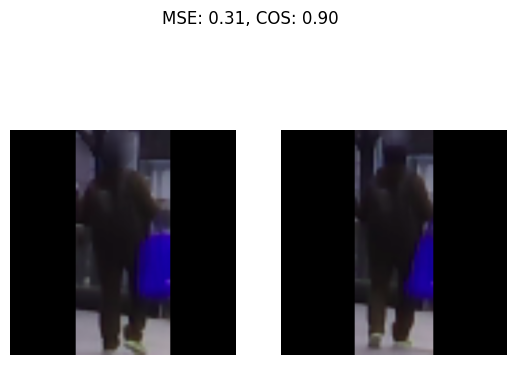

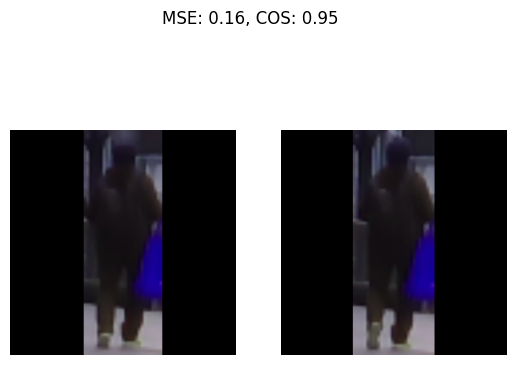

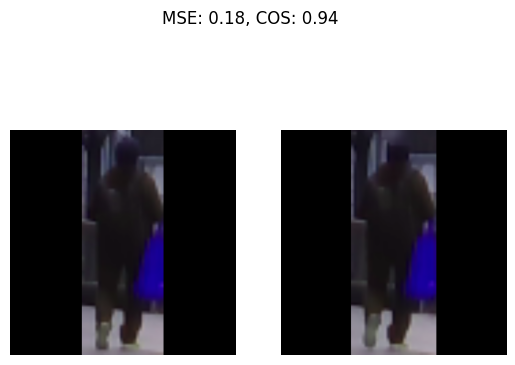

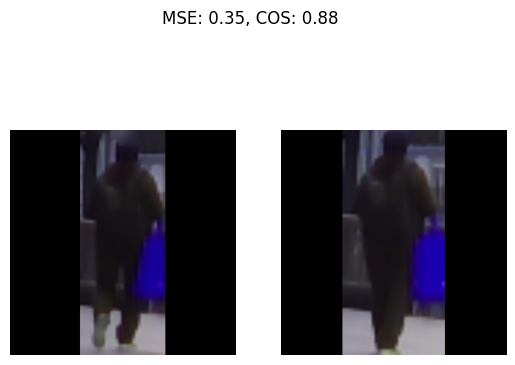

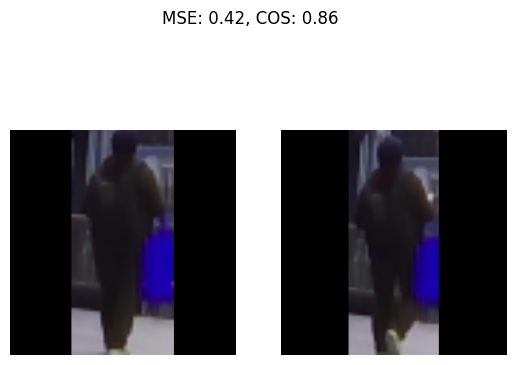

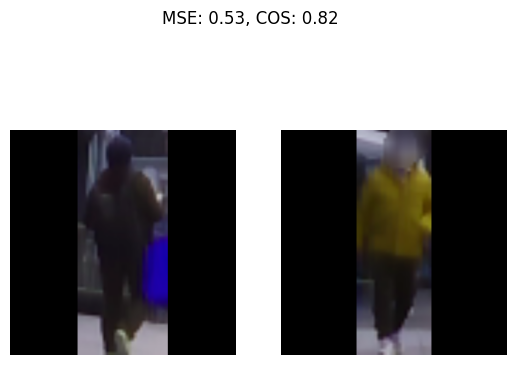

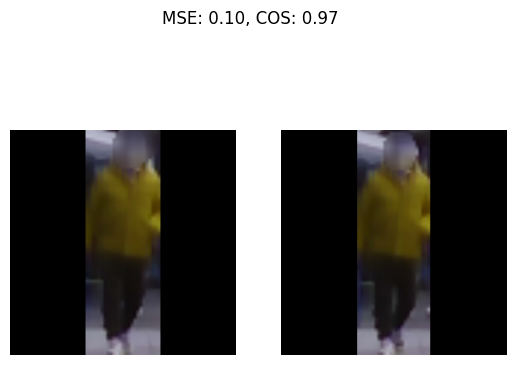

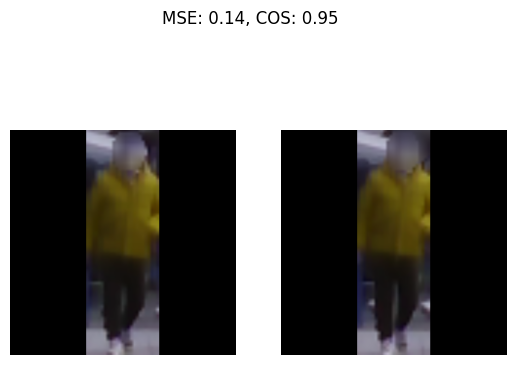

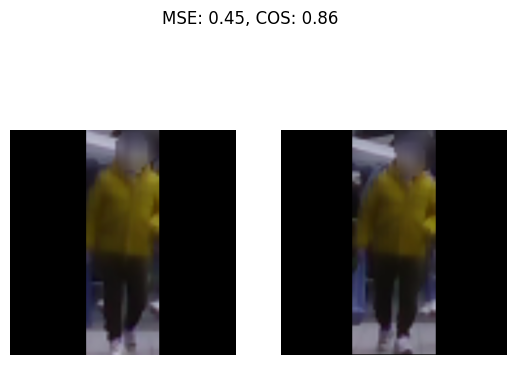

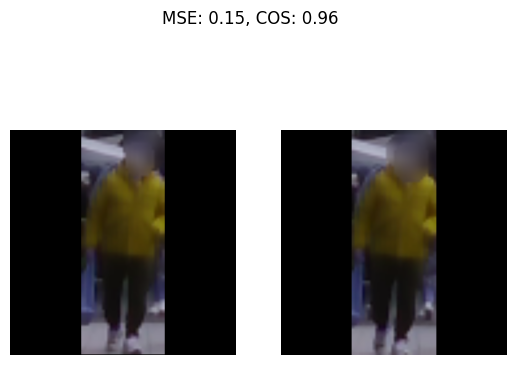

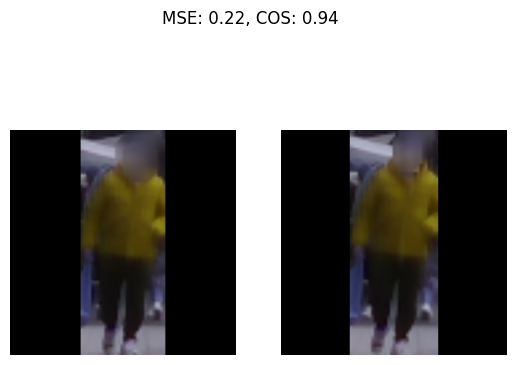

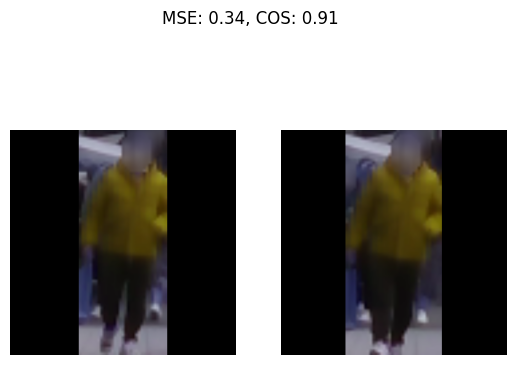

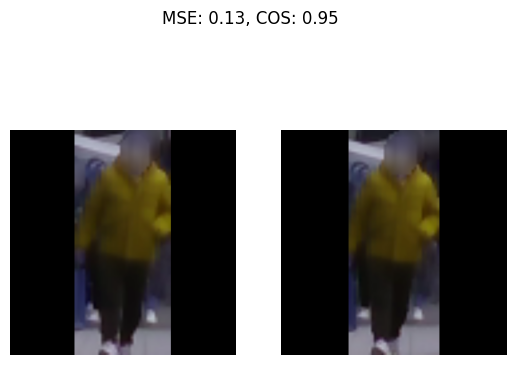

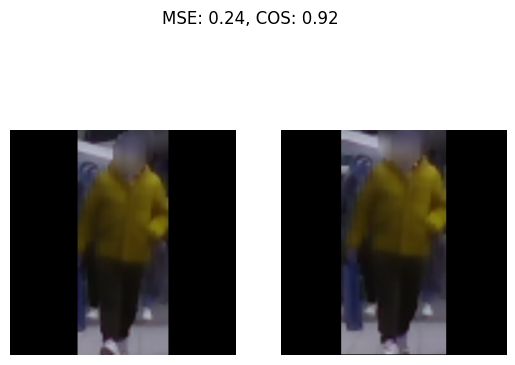

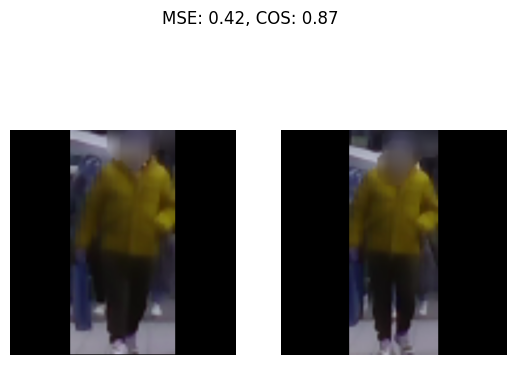

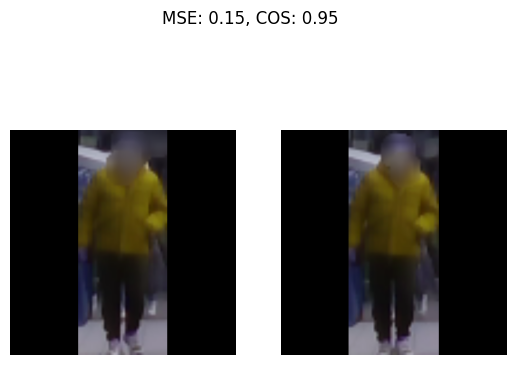

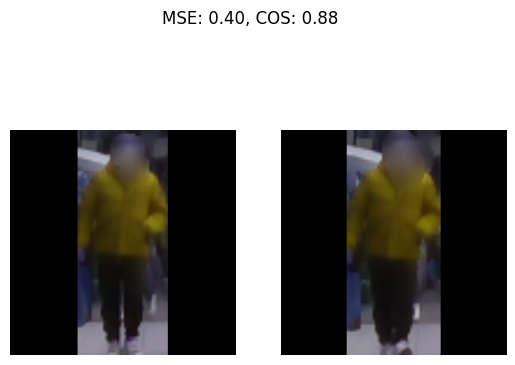

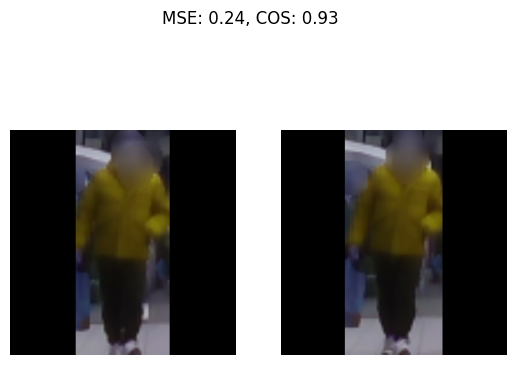

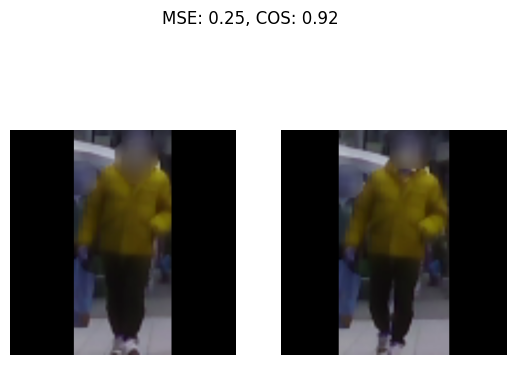

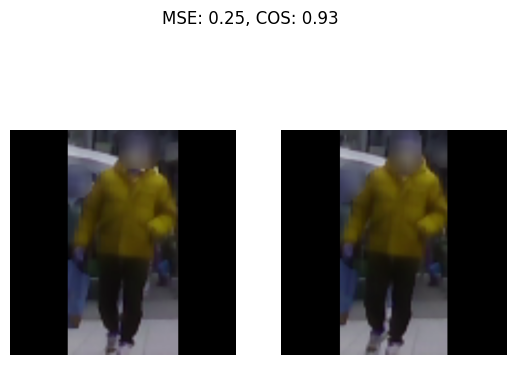

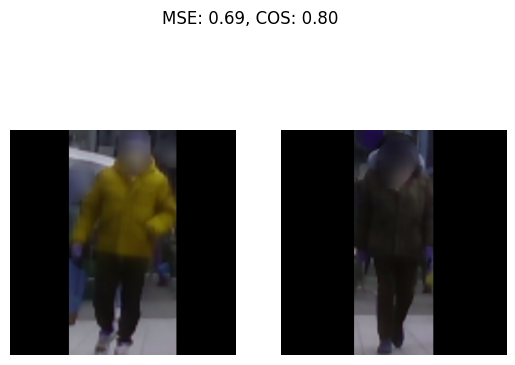

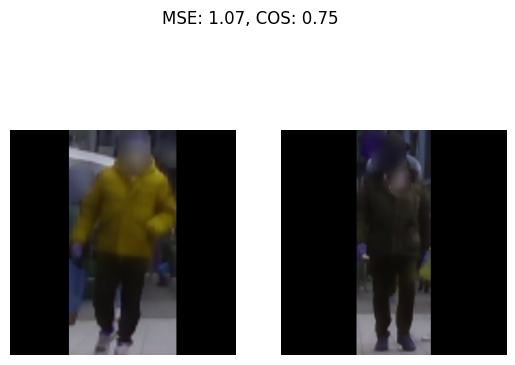

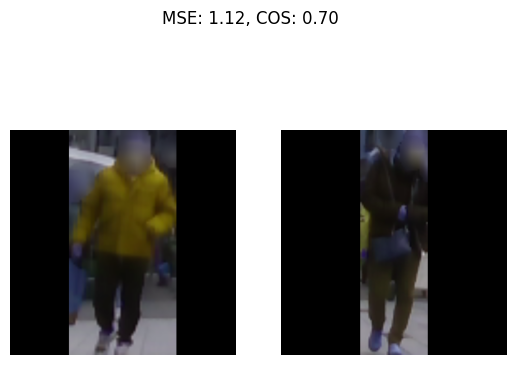

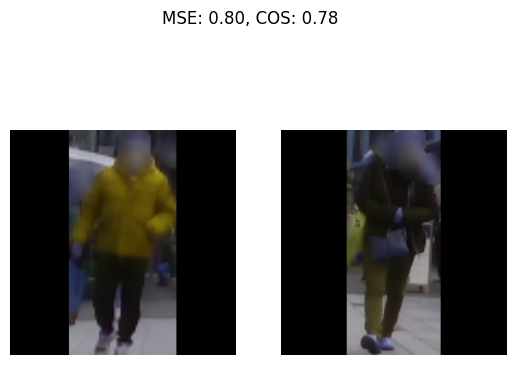

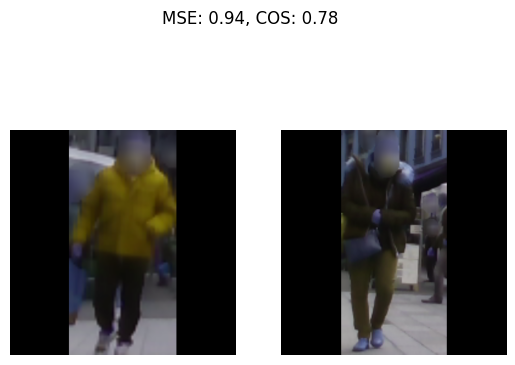

In [76]:
filter_tracks2(258,sync_data)

In [81]:
unpickled_df = pd.read_pickle("../full_tracks.pkl") 
unpickled_df 

voxelgrids  \
0   [[[41, 35], [73, 30], [69, 27], [73, 31], [21,...   
1   [[[33, 37], [72, 33], [18, 33], [73, 34], [72,...   
2   [[[33, 37], [72, 33], [18, 33], [73, 34], [72,...   
3   [[[35, 17], [66, 56], [34, 20], [24, 36], [26,...   
4   [[[45, 34], [31, 48], [26, 38], [32, 47], [24,...   
5   [[[25, 41], [26, 40], [20, 42], [16, 49], [17,...   
6   [[[53, 63], [39, 22], [41, 18], [42, 53], [38,...   
7   [[[14, 73], [7, 85], [18, 63], [0, 85], [18, 6...   
8   [[[44, 63], [43, 62], [34, 44], [48, 45], [42,...   
9   [[[25, 18], [27, 23], [59, 52], [26, 19], [32,...   
10  [[[30, 69], [57, 50], [29, 73], [29, 72], [28,...   

                                            positions  \
0   [[3.8513370004132086, -0.17450667955808613, 9....   
1   [[0.6341347125339921, -0.22643121078541828, 6....   
2   [[1.3788405733471636, -0.2957796984245383, 6.6...   
3   [[-0.6076898097326956, -0.32990159934117197, 1...   
4   [[-0.6604592948254949, -0.41700540248099555, 1...   
5   [[-0.1454085097305414, 0.020261408540531305, 5...   
6   [[-0.47203024386180764, -0.008346850567808737,...   
7   [[0.7779573725492831, -0.17432153774737316, 6....   
8   [[0.37841049277261674, -0.04149553084741373, 5...   
9   [[1.2498311506861015, -0.21298674880062032, 6....   
10  [[3.9721298117424158, 0.11489396159258426, 9.5...   

                                                poses  
0   [[[22.0, 11.0, 0.41652125120162964], [25.0, 10...  
1   [[[49.0, 26.0, 0.4822697341442108], [48.0, 23....  
2   [[[21.0, 20.0, 0.2838587760925293], [26.0, 14....  
3   [[[7.0, 9.0, 0.3584122359752655], [9.0, 7.0, 0...  
4   [[[14.0, 7.0, 0.5101683139801025], [16.0, 5.0,...  
5   [[[20.0, 9.0, 0.3641936182975769], [18.0, 7.0,...  
6   [[[8.0, 11.0, 0.34182512760162354], [8.0, 9.0,...  
7   [[[10.0, 22.0, 0.39039695262908936], [12.0, 19...  
8   [[[31.0, 23.0, 0.4630606472492218], [28.0, 20....  
9   [[[26.0, 7.0, 0.48276105523109436], [30.0, 4.0...  
10  [[[15.0, 5.0, 0.41195428371429443], [16.0, 3.0...

In [83]:
unpickled_df.iloc[0].positions

array([[ 3.851337  , -0.17450668,  9.357     ],
       [ 3.79412466, -0.17191435,  9.218     ],
       [ 3.7493572 , -0.17191435,  9.218     ],
       [ 3.7493572 , -0.1569993 ,  9.218     ],
       [ 3.62626656, -0.16693484,  8.951     ],
       [ 3.56012762, -0.16454766,  8.823     ],
       [ 3.34517816, -0.17146634,  8.46      ],
       [ 3.33148276, -0.18515493,  8.46      ],
       [ 3.33148276, -0.17146634,  8.46      ],
       [ 3.27670114, -0.2125321 ,  8.46      ],
       [ 2.82375054, -0.23228012,  7.352     ],
       [ 2.61333472, -0.20569603,  6.862     ]])